Link dataset: https://www.kaggle.com/datasets/puneet6060/intel-image-classification/data

# Import Library
Pada bagian ini dilakukan import berbagai library penting yang digunakan dalam pemrosesan citra, pembuatan model deep learning, dan evaluasi model:
- `os`: Mengelola struktur direktori dan file.
- `numpy`, `pandas`: Untuk manipulasi data numerik dan tabular.
- `seaborn`, `matplotlib.pyplot`: Untuk visualisasi data dan hasil model.
- `PIL.Image`: Untuk membuka dan memproses file gambar.
- `tensorflow.keras`: Modul utama untuk membuat, melatih, dan menyimpan model CNN.
- `ImageDataGenerator`: Untuk augmentasi dan normalisasi gambar.
- `classification_report`, `confusion_matrix`: Untuk evaluasi performa klasifikasi model.

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras import layers, models, Input
from tensorflow.keras.models import load_model

from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from sklearn.metrics import classification_report, confusion_matrix

print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.18.0


# Menetapkan path dataset

In [ ]:
base_dir = 'D:/SEMESTER6/Tugas 3 Lab ML/intel-image-classification'
train_dir = os.path.join(base_dir, 'seg_train')
test_dir = os.path.join(base_dir, 'seg_test')

print(f"Train directory: {train_dir}")
print(f"Test directory: {test_dir}")
print(f"Train directory exists: {os.path.exists(train_dir)}")
print(f"Test directory exists: {os.path.exists(test_dir)}")

Train directory: D:/SEMESTER6/Tugas 3 Lab ML/intel-image-classification\seg_train
Test directory: D:/SEMESTER6/Tugas 3 Lab ML/intel-image-classification\seg_test
Train directory exists: True
Test directory exists: True


# Validasi dan Pembersihan Gambar Rusak

Fungsi ini melakukan:
- Validasi setiap file gambar dengan mencoba membuka dan memuatnya.
- Menghapus file gambar yang rusak atau tidak dapat diidentifikasi.
- Mengonversi gambar yang tidak berwarna (non-RGB) menjadi format RGB agar konsisten dengan input CNN.

Proses ini membantu mencegah error saat proses training yang diakibatkan oleh file gambar yang rusak atau tidak valid.

In [ ]:
def validate_and_clean_images(directory):
    """Memvalidasi dan membersihkan gambar yang rusak dalam direktori."""
    removed_count = 0
    converted_count = 0
    for root, dirs, files in os.walk(directory):
        for file in files:
            if not file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                continue
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()
                img = Image.open(file_path)
                img.load()
                if img.mode != 'RGB':
                     print(f"Converting non-RGB image {file_path} to RGB: mode={img.mode}")
                     rgb_img = img.convert('RGB')
                     rgb_img.save(file_path)
                     print(f"Converted {file_path} to RGB.")
                     converted_count +=1

            except (IOError, SyntaxError, Image.UnidentifiedImageError) as e:
                print(f"Removing corrupted image {file_path}: {e}")
                try:
                    os.remove(file_path)
                    removed_count += 1
                except OSError as oe:
                     print(f"Could not remove file {file_path}: {oe}")
            except Exception as e:
                print(f"Unexpected error with image {file_path}: {e}")
                try:
                    os.remove(file_path)
                    removed_count += 1
                except OSError as oe:
                     print(f"Could not remove file {file_path}: {oe}")

    print(f"Finished processing directory: {directory}.")
    print(f"Removed {removed_count} potentially problematic files.")
    print(f"Converted {converted_count} non-RGB files to RGB.")

print("Cleaning train directory...")
validate_and_clean_images(train_dir)
print("\nCleaning test directory...")
validate_and_clean_images(test_dir)

Cleaning train directory...
Finished processing directory: D:/SEMESTER6/Tugas 3 Lab ML/intel-image-classification\seg_train.
Removed 0 potentially problematic files.
Converted 0 non-RGB files to RGB.

Cleaning test directory...
Finished processing directory: D:/SEMESTER6/Tugas 3 Lab ML/intel-image-classification\seg_test.
Removed 0 potentially problematic files.
Converted 0 non-RGB files to RGB.


# Persiapan Data Generator untuk Training dan Testing
Di sini dibuat `ImageDataGenerator` untuk:
- **Training**: Dengan augmentasi gambar agar model lebih generalisasi.
- **Validation dan Test**: Hanya dilakukan rescaling (normalisasi piksel dari 0-255 menjadi 0-1).
- `flow_from_directory` digunakan untuk membaca gambar dari folder dan mengelompokkannya berdasarkan label (subfolder). Juga diatur agar data training dibagi menjadi 80% training dan 20% validasi.
Selain itu, juga diambil daftar nama kelas dan jumlah total kelas target.



In [ ]:
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2

# Augmentasi data training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=VALIDATION_SPLIT
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Membuat generator data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)
print(f"Class names found: {class_names}")
print(f"Number of classes: {num_classes}")

Found 5390 images belonging to 3 classes.
Found 1346 images belonging to 3 classes.
Found 1421 images belonging to 3 classes.
Class names found: ['buildings', 'forest', 'sea']
Number of classes: 3


# Membangun Arsitektur Model CNN
CNN dibangun menggunakan `Sequential API` dengan arsitektur sebagai berikut:
- 3 layer konvolusi bertingkat (Conv2D + MaxPooling2D).
- 1 layer Flatten untuk meratakan output.
- 1 layer Dense dengan 512 neuron dan dropout 0.5 untuk mencegah overfitting.
- 1 layer output Dense dengan `softmax` sebanyak jumlah kelas.

Model ini cocok untuk klasifikasi multi-kelas pada data gambar.

In [5]:
# Sel 5: Membangun Model CNN

model = models.Sequential([
    Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # layers.Conv2D(128, (3, 3), activation='relu'), # Bisa ditambahkan jika performa kurang
    # layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,035,203 (72.61 MB)

 Trainable params: 19,035,203 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

# Callback dan Kompilasi Model
- `ModelCheckpoint`: Menyimpan model terbaik selama training berdasarkan akurasi validasi tertinggi.
- `EarlyStopping`: Menghentikan pelatihan dini jika tidak ada perbaikan dalam `val_loss` selama beberapa epoch.
- Model dikompilasi menggunakan `Adam` optimizer dengan learning rate kecil (`0.0005`) dan `categorical_crossentropy` sebagai loss function (karena klasifikasi multi-kelas).

In [ ]:
model_checkpoint_callback = ModelCheckpoint(
    filepath='model_intel_best.keras',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

# Kompilasi model
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Melatih Model
Model dilatih menggunakan `fit()` dengan data generator yang telah dibuat. Jumlah `steps_per_epoch` dan `validation_steps` dihitung berdasarkan jumlah data dan ukuran batch. Callback untuk `ModelCheckpoint` dan `EarlyStopping` digunakan selama pelatihan.

Output dari proses ini adalah variabel `history` yang menyimpan nilai loss dan akurasi untuk setiap epoch.

In [ ]:
EPOCHS = 30

steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = validation_generator.samples // BATCH_SIZE
if train_generator.samples % BATCH_SIZE > 0:
    steps_per_epoch += 1
if validation_generator.samples % BATCH_SIZE > 0:
    validation_steps += 1

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")


history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        early_stopping_callback
        ]
)

Steps per epoch: 169
Validation steps: 43


c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 874ms/step - accuracy: 0.6385 - loss: 0.8091
Epoch 1: val_accuracy improved from -inf to 0.88707, saving model to model_intel_best.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 160s 928ms/step - accuracy: 0.6392 - loss: 0.8076 - val_accuracy: 0.8871 - val_loss: 0.3167
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/30


c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 781ms/step - accuracy: 0.8664 - loss: 0.3629
Epoch 3: val_accuracy did not improve from 0.88707
169/169 ━━━━━━━━━━━━━━━━━━━━ 139s 822ms/step - accuracy: 0.8665 - loss: 0.3627 - val_accuracy: 0.8611 - val_loss: 0.3816
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 188us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 797ms/step - accuracy: 0.8708 - loss: 0.3332
Epoch 5: val_accuracy did not improve from 0.88707
169/169 ━━━━━━━━━━━━━━━━━━━━ 142s 839ms/step - accuracy: 0.8709 - loss: 0.3330 - val_accuracy: 0.8663 - val_loss: 0.3546
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 869ms/step - accuracy: 0.9074 - loss: 0.2536
Epoch 7: val_accuracy improved from 0.88707 to 0.94056, saving model to model_intel_best.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 156s 921ms/step - accuracy: 0.9075 - loss: 0.2535 - val_accuracy: 0.9406 - val_loss: 0.

# Evaluasi Model pada Data Validasi dan Test
Model terbaik yang disimpan selama training dimuat dari file `.keras`. Jika gagal dimuat, model terakhir akan digunakan sebagai fallback.
Dilakukan evaluasi pada:
- **Data Validasi**: Untuk melihat performa model pada data yang belum dilatih tapi dari domain yang sama.
- **Data Test**: Untuk mengevaluasi generalisasi model pada data yang sepenuhnya baru.

In [ ]:
best_model_path = 'model_intel_best.keras'
model_best = None

if os.path.exists(best_model_path):
    try:
        model_best = tf.keras.models.load_model(best_model_path)
        print(f"Loaded best model from {best_model_path}")
    except Exception as e:
        print(f"Could not load .keras model from {best_model_path}: {e}")
        model_best = None

if model_best is None:
    print("Could not load saved best model. Using the model from the end of training.")
    model_best = model

# Evaluasi pada data validasi
print("\nEvaluating on Validation Data:")
val_loss, val_accuracy = model_best.evaluate(validation_generator, verbose=1)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

# Evaluasi pada data test
print("\nEvaluating on Test Data:")
test_loss, test_accuracy = model_best.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Loaded best model from model_intel_best.keras

Evaluating on Validation Data:
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 170ms/step - accuracy: 0.9607 - loss: 0.1159
Validation Accuracy: 0.9584
Validation Loss: 0.1189

Evaluating on Test Data:
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - accuracy: 0.9777 - loss: 0.0901
Test Accuracy: 0.9719
Test Loss: 0.1005


# Confusion Matrix dan Classification Report
Dilakukan prediksi terhadap seluruh data uji, lalu hasilnya dibandingkan dengan label asli untuk:
- Menampilkan **confusion matrix** dalam bentuk heatmap.
- Menampilkan **classification report** (precision, recall, f1-score per kelas).

Cell ini juga menangani kemungkinan mismatch antara jumlah prediksi dan label asli karena batch size yang tidak membagi habis jumlah sampel.


Generating predictions for Test Data...
Test samples: 1421, Batch size: 32, Test steps: 45
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 191ms/step
Class Labels for report: ['buildings', 'forest', 'sea']


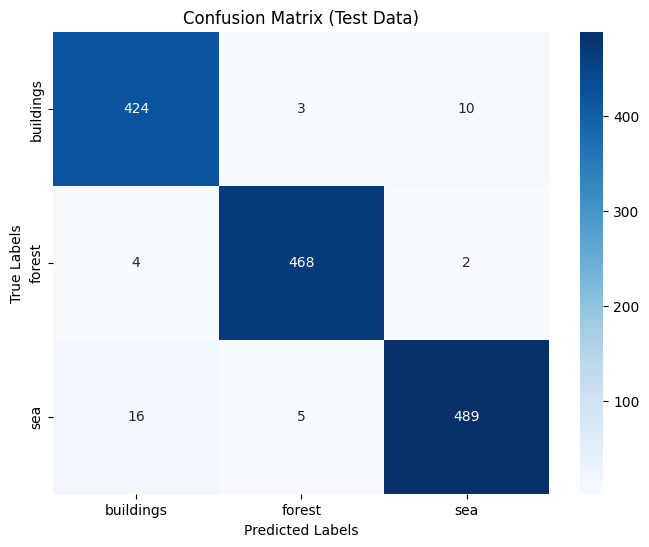


Classification Report (Test Data):
              precision    recall  f1-score   support

   buildings       0.95      0.97      0.96       437
      forest       0.98      0.99      0.99       474
         sea       0.98      0.96      0.97       510

    accuracy                           0.97      1421
   macro avg       0.97      0.97      0.97      1421
weighted avg       0.97      0.97      0.97      1421



In [ ]:
print("\nGenerating predictions for Test Data...")

test_generator.reset()

num_test_samples = test_generator.samples
batch_size = test_generator.batch_size
test_steps = int(np.ceil(num_test_samples / batch_size))
print(f"Test samples: {num_test_samples}, Batch size: {batch_size}, Test steps: {test_steps}")

predictions = model_best.predict(test_generator,
                                steps=test_steps,
                                verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

true_labels = test_generator.classes

if len(predicted_classes) > len(true_labels):
    print(f"Warning: Number of predictions ({len(predicted_classes)}) is greater than true labels ({len(true_labels)}). Truncating predictions.")
    predicted_classes = predicted_classes[:len(true_labels)]
elif len(true_labels) > len(predicted_classes):
     print(f"Warning: Number of true labels ({len(true_labels)}) is greater than predictions ({len(predicted_classes)}). This might indicate an issue.")

     true_labels = true_labels[:len(predicted_classes)]

class_labels = list(test_generator.class_indices.keys())
print(f"Class Labels for report: {class_labels}")

conf_matrix = confusion_matrix(true_labels, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Test Data)')
plt.show()

print("\nClassification Report (Test Data):")
class_report = classification_report(true_labels, predicted_classes, target_names=class_labels)
print(class_report)

# Visualisasi Performa Model
Menggunakan `matplotlib`, ditampilkan dua grafik:
- **Loss vs Epoch**: Untuk memantau convergence dan overfitting.
- A**ccuracy vs Epoch**: Untuk melihat peningkatan performa selama training.
Visualisasi ini membantu dalam menganalisis perilaku model selama pelatihan.

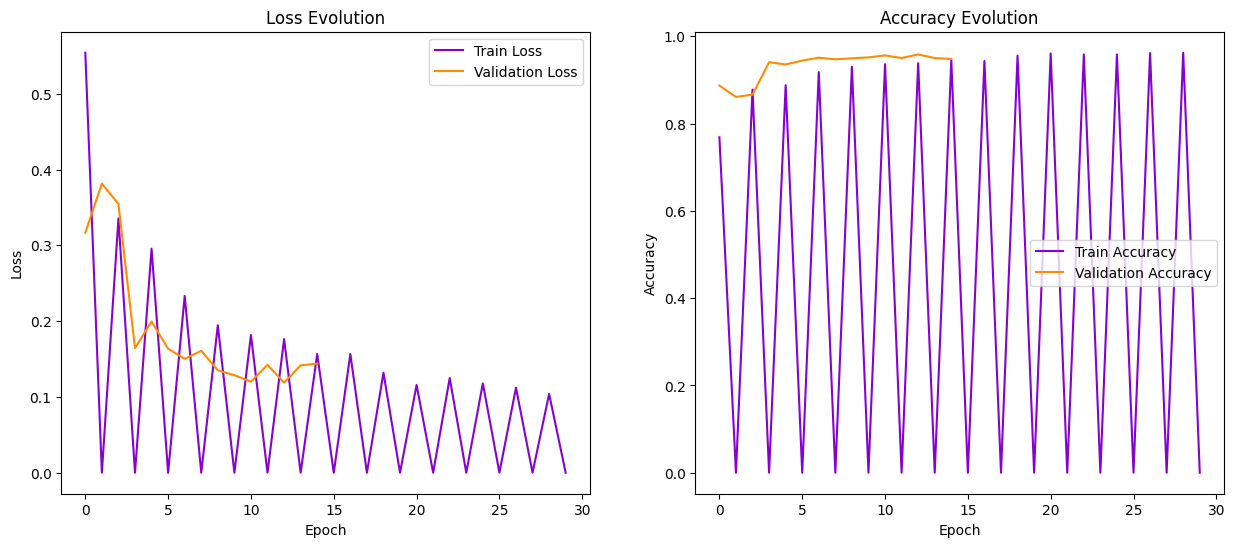

In [ ]:
plt.figure(figsize=(15, 6))

# Plotting the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='#8502d1')
plt.plot(history.history['val_loss'], label='Validation Loss', color='darkorange')
plt.legend()
plt.title('Loss Evolution')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='#8502d1')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='darkorange')
plt.legend()
plt.title('Accuracy Evolution')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

# Menampilkan Contoh Prediksi
Mnampilkan beberapa gambar dari data test lengkap dengan:
- Label sebenarnya.
- Label hasil prediksi.
- Warna hijau untuk prediksi benar, merah untuk salah.

Gambar ditampilkan dalam grid dan dapat diatur berapa banyak gambar yang ingin ditampilkan dengan parameter `num_images`.


Displaying sample predictions from Test Data:


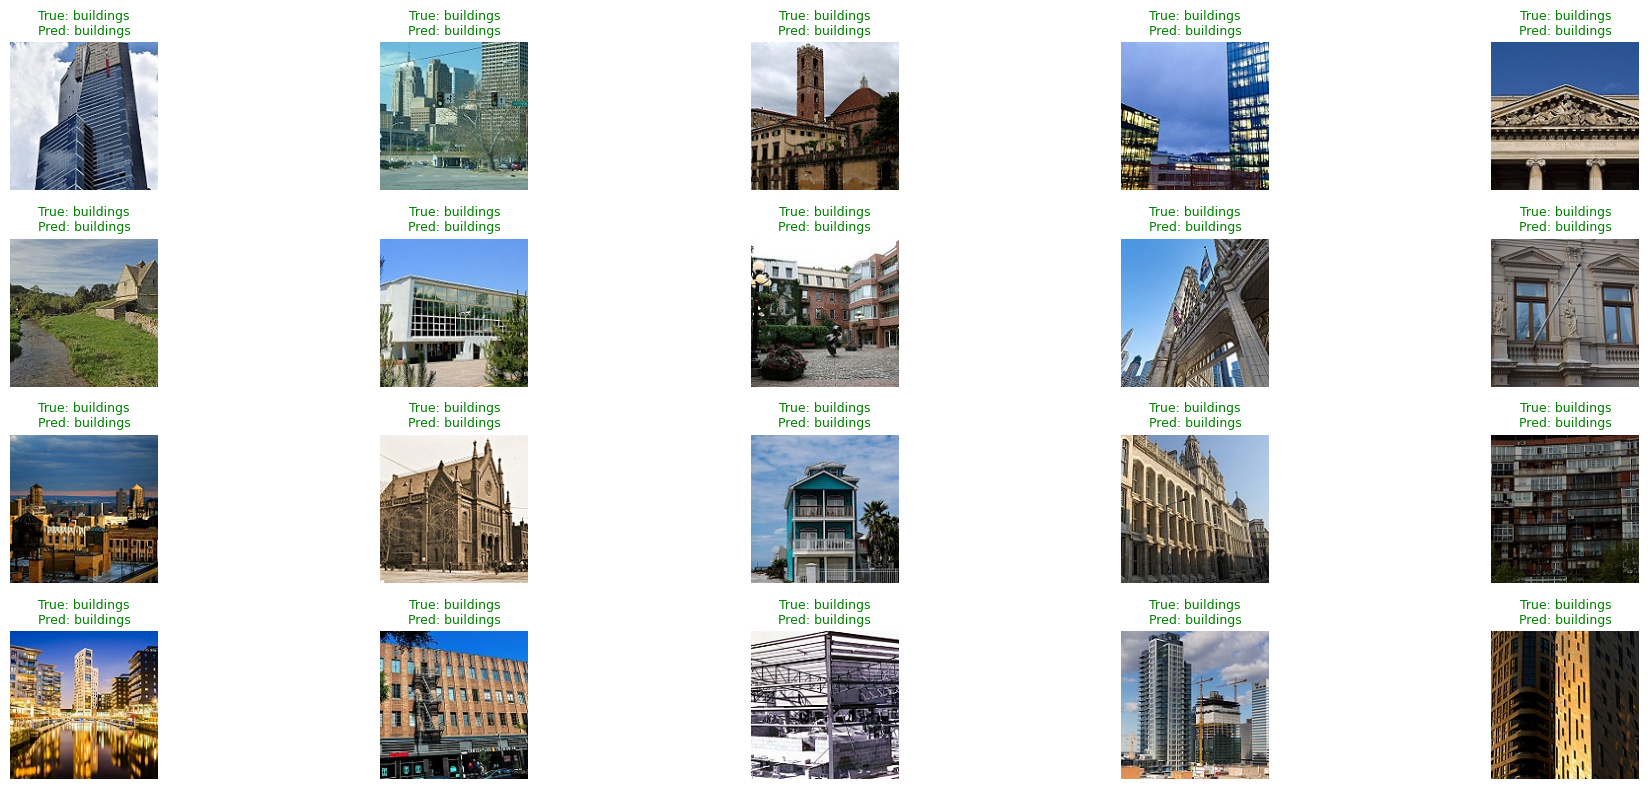

In [ ]:
# Fungsi untuk menampilkan gambar dan prediksinya
def display_predictions(model, generator, class_names, num_images=20):
    plt.figure(figsize=(20, 8))

    generator.reset()

    actual_shown = 0
    batch_count = 0
    max_batches = np.ceil(num_images / generator.batch_size) + 1

    while actual_shown < num_images and batch_count < max_batches:
         try:
             img_batch, label_batch = next(generator)
             batch_count += 1
         except StopIteration:
             print("Generator reached end before showing enough images.")
             break

         pred_batch = model.predict(img_batch, verbose=0)

         for i in range(len(img_batch)):
             if actual_shown >= num_images:
                 break

             true_class_idx = np.argmax(label_batch[i])
             pred_class_idx = np.argmax(pred_batch[i])

             if true_class_idx >= len(class_names) or pred_class_idx >= len(class_names):
                 print(f"Warning: Class index out of bounds. Skipping image {actual_shown+1}")
                 continue

             true_class = class_names[true_class_idx]
             pred_class = class_names[pred_class_idx]

             rows = int(np.ceil(num_images / 5))
             plt.subplot(rows, 5, actual_shown + 1)
             plt.imshow(img_batch[i])
             plt.title(f"True: {true_class}\nPred: {pred_class}",
                       color="green" if true_class == pred_class else "red",
                       fontsize=9)
             plt.axis('off')
             actual_shown += 1

    plt.tight_layout()
    plt.show()

class_names_display = list(test_generator.class_indices.keys())

print("\nDisplaying sample predictions from Test Data:")
display_predictions(model_best, test_generator, class_names_display, num_images=20)

# Konversi Model ke Format TensorFlow Lite
Model terbaik dikonversi ke format .tflite agar bisa digunakan di perangkat mobile atau embedded system.

Langkah-langkah:
- Menggunakan `TFLiteConverter` dari model Keras.
- Disimpan ke file `.tflite`.
- Menampilkan ukuran akhir dari model hasil konversi.

In [ ]:
import tensorflow as tf
import os

tflite_model_path = 'model_intel.tflite'

if model_best:
    print(f"\nConverting to TensorFlow Lite format (float32)...")
    try:
        converter = tf.lite.TFLiteConverter.from_keras_model(model_best)
        tflite_model = converter.convert()

        with open(tflite_model_path, 'wb') as f:
            f.write(tflite_model)
        print(f"Successfully converted and saved float32 TFLite model to: {tflite_model_path}")
        print(f"Model size: {os.path.getsize(tflite_model_path) / 1024:.2f} KB")
    except Exception as e:
        print(f"Error during TFLite conversion: {e}")
else:
    print("Best model is not available for TFLite conversion.")


Converting to TensorFlow Lite format (float32)...
INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmpe09y4fde\assets


INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmpe09y4fde\assets


Saved artifact at 'C:\Users\USER\AppData\Local\Temp\tmpe09y4fde'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2568282951312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2568282950736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2568282961872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2568282962832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2568377681296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2568377680720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2568377683600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2568377683984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2568377681104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2568377684560: TensorSpec(shape=(), dtype=tf.resource, name=None)
Successfu